# Conditional variance and entropy

This example will show you how to use {func}`moscot.problems.time.TemporalProblem.compute_entropy` 
and {func}`moscot.problems.time.TemporalProblem.compute_variance`.


Conditional entropy and conditional variance are measures to calculate the uncertainty of a solution 
to an optimal transport problem. \
The conditional entropy calculates the general uncertainty of a mapping from or to a specific cell 
by computing the entropy of the transport plan. 
The conditional variance calculates the uncertainty by computing the variance of the mapping from or to a specific 
cell with respect to a given feature space.

:::{seealso}
- See {doc}`../../tutorials/200_temporal_problem` on how to solve temporal problems.
:::

## Imports and data loading

In [1]:
from moscot import datasets
from moscot.problems.time import TemporalProblem

import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc

We will define a {class}`~moscot.problems.time.TemporalProblem` using the {func}`~moscot.datasets.hspc` dataset, 
which contains measurements on blood development.

In [2]:
adata = datasets.hspc()
adata

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

In [3]:
tp = TemporalProblem(adata)

## Solving the problem 

Now we solve the problem with adjusted marginals.

In [4]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

       'BUB1', 'CASP8AP2', 'CBX5', 'CCNB2', 'CCNE2', 'CDC20', 'CDC25C',
       'CDC45', 'CDC6', 'CDCA2', 'CDCA3', 'CDCA7', 'CDCA8', 'CDK1', 'CENPA',
       'CENPF', 'CHAF1B', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CLSPN',
       'CTCF', 'DLGAP5', 'DSCC1', 'DTL', 'E2F8', 'ECT2', 'EXO1', 'FAM64A',
       'FEN1', 'G2E3', 'GAS2L3', 'GINS2', 'GMNN', 'GTSE1', 'HELLS', 'HJURP',
       'HMGB2', 'HMMR', 'HN1', 'KIF11', 'KIF20B', 'KIF23', 'KIF2C', 'LBR',
       'MCM2', 'MCM4', 'MCM5', 'MCM6', 'MLF1IP', 'MSH2', 'NASP', 'NCAPD2',
       'NDC80', 'NEK2', 'NUF2', 'NUSAP1', 'PCNA', 'POLA1', 'POLD3', 'PRIM1',
       'PSRC1', 'RAD51', 'RAD51AP1', 'RANGAP1', 'RFC2', 'RPA2', 'RRM1', 'RRM2',
       'SLBP', 'SMC4', 'TACC3', 'TIPIN', 'TMPO', 'TOP2A', 'TPX2', 'TTK',
       'TUBB4B', 'TYMS', 'UBR7', 'UHRF1', 'UNG', 'USP1', 'WDR76'],
      dtype='object')
       'BCAP31', 'BCL10',
       ...
       'TIMP2', 'TNF', 'TNFRSF12A', 'TNFSF10', 'TOP2A', 'TSPO', 'TXNIP',
       'VDAC2', 'WEE1', 'XIAP'],
      d

In [5]:
tp = tp.prepare(time_key="day", joint_attr="X_pca")

In [6]:
tp = tp.solve(epsilon=5 * 1e-3, tau_a=0.99, tau_b=0.999, scale_cost="mean")

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(766, 1235)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1235, 1201)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1201, 798)].                                   


## Basic parameters

Both {func}moscot.problems.time.TemporalProblem.compute_entropy and {func}moscot.problems.time.TemporalProblem.compute_variance share the majority of the input parameters, here we explain the most important ones:

- `forward` determines on which set of cells we will compute our measure of uncertainty. We set `forward` to {obj}`True`
   if we want to compute the conditional entropy or variance on the cells in the source distribution and set it to
  {obj}`False` if we want to compute the conditional entropy or variance on the cells in the target distribution.
- Depending on the problem and our hardware, we may be unable to compute the conditional variance
  or entropy on the entire set of selected cells. In this case we can use `batch_size` to divide the set into batches that are of
  a suitable size for the computation process.
- If `key_added` is {obj}`None`, the function returns the computed entropy or variance to the assigned variable. If `key_added`
  is a string, we will append the computed entropy or array to `anndata.AnnData.obs` with the key provided by `key_added`.

Additionally for {func}moscot.problems.time.TemporalProblem.compute_variance we have the option to select the feature space on which we want to compute the variance. To do this, we can set `latent_space_selection` to one of the following possibilities:
- A feature space from {class}`anndata.AnnData.obsm` like `"X_pca"`
- A single gene from {class}`anndata.AnnData.var_names` like `"ABCA8"`
- A subset of genes from {class}`anndata.AnnData.var_names` like `["ABLIM1", "LOC105371824", "AREG"]`

## Demonstration

To demonstrate the functions, we look at the mapping from the cells at timepoint `4` to cells at timepoint `7` and compute the conditional entropy and conditional variances of each cell at timepoint `7`.

In [7]:
cond_entropy = tp.compute_entropy(
    source=4, target=7, forward=False, key_added="entropy", batch_size=10
)

In [8]:
cond_variance_pca = tp.compute_variance(
    source=4,
    target=7,
    forward=False,
    key_added="variance_pca",
    batch_size=10,
    latent_space_selection="X_pca",
)

In [9]:
cond_variance_gene = tp.compute_variance(
    source=4,
    target=7,
    forward=False,
    key_added="variance_gene",
    batch_size=10,
    latent_space_selection="ABCA8",
)

In [10]:
cond_variance_genes = tp.compute_variance(
    source=4,
    target=7,
    forward=False,
    key_added="variance_genes",
    batch_size=10,
    latent_space_selection=["ABLIM1", "LOC105371824", "AREG"],
)

Since we provided a value for `key_added` in each function call, we verify that our computed arrays were added to 
`anndata.AnnData.obs`.

In [11]:
adata

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes', 'proliferation', 'apoptosis', 'entropy', 'variance_pca', 'variance_gene', 'variance_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

## Visualization

We can now visualize both measures of uncertainty. 

We plot both the conditional entropy as well as the conditional variances computed on the cells at timepoint `7`.

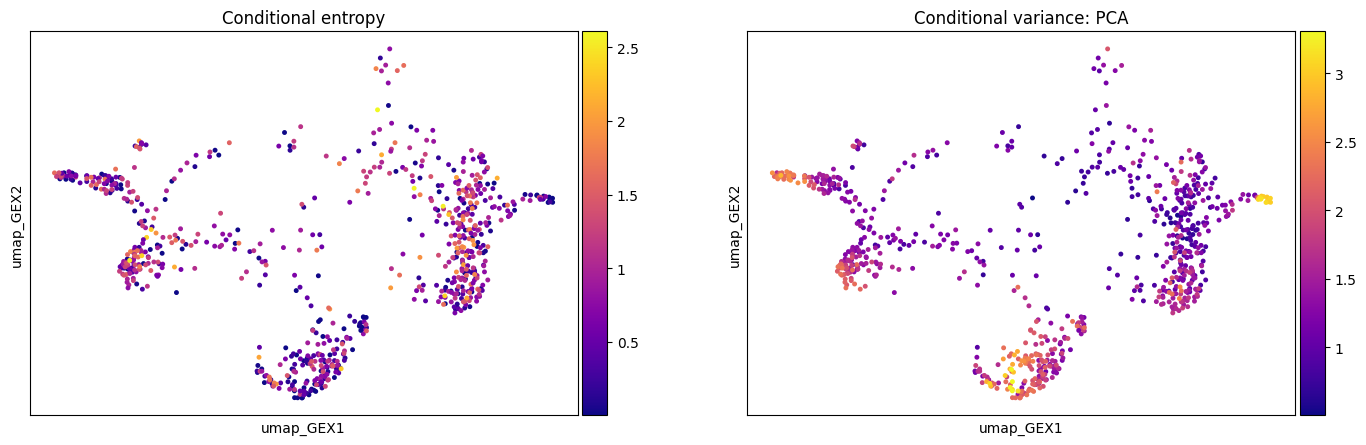

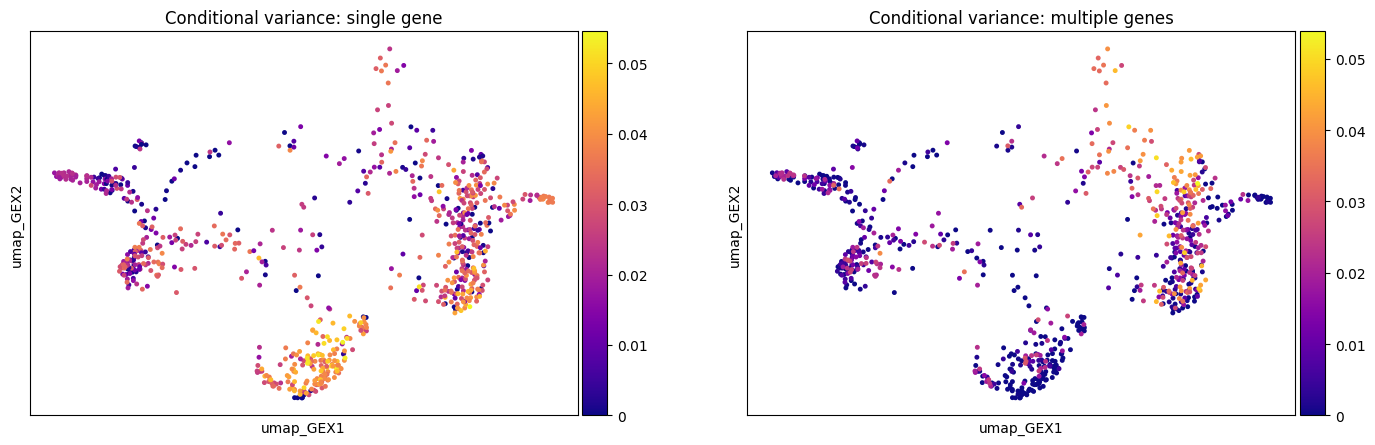

In [12]:
sc.pl.scatter(
    adata,
    basis="umap_GEX",
    color=["entropy", "variance_pca"],
    size=50,
    color_map="plasma",
    title=["Conditional entropy", "Conditional variance: PCA"],
)
sc.pl.scatter(
    adata,
    basis="umap_GEX",
    color=["variance_gene", "variance_genes"],
    size=50,
    color_map="plasma",
    title=["Conditional variance: single gene", "Conditional variance: multiple genes"],
)